In [1]:
import torch
import torchkbnufft as tkbn
import scipy.io as sio
import matplotlib.pyplot as plt
import math
import numpy as np
from utils import *

In [2]:
def inufft2c_torch(data, ktraj, sens, dim):
    # JBM implemented
    inufft_ob = tkbn.KbNufftAdjoint(im_size=(dim,dim),)
    image = inufft_ob(data, ktraj, smaps=sens, norm='ortho')
#     print('inufft Not tested')
    return image
    #return torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(data, dim), dim=dim), dim=dim)

def nufft2c_torch(data, ktraj, sens, dim):
    # JBM implemented
    nufft_ob = tkbn.KbNufft(im_size=(dim, dim),)
    kdata = nufft_ob(data, ktraj, smaps=sens, norm='ortho')
#     print('nufft Not tested')
    return kdata
    #return torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(data, dim), dim=dim), dim=dim)

In [3]:
rosdat = sio.loadmat('data/rosette_ferret_data_NOVD_7T.mat')
print(np.shape(rosdat['kxI']))
print(np.shape(rosdat['sigI']))
print(np.shape(rosdat['t']))

(671, 40)
(671, 40)
(671, 1)


In [4]:


# Exporting for reconstruction: 
# these are my (manually selected) time bins. Half of an in-out, so full k-space coverage 
# bin_bots = [12, 80, 144, 208, 270, 334, 398, 462, 526, 594] 
bin_bots = [12, 80, 144, 208, 270, 334, 398, 462] 
Ro_len = 150 #68
bin_tops = [x+Ro_len for x in bin_bots]

N_contrasts = len(bin_bots)
N_slices = 1
N_coils = 1
Nshots = 40
Nx, Ny = 100, 100
# establish number of contrasts: 
kdata = torch.zeros(N_contrasts, N_coils, Nshots*Ro_len,dtype=torch.cdouble)
ktraj = torch.zeros(N_contrasts, 2, Nshots*Ro_len)
dcomp = torch.zeros(N_contrasts, 1, Nshots*Ro_len, dtype=torch.cdouble)
sens = torch.ones(N_contrasts, N_coils, Nx, Ny, dtype=torch.cdouble)
for ii in range(len(bin_bots)):
    print('bin:', ii)
    kdata[ii,0,:] = torch.from_numpy(rosdat['sigI'][bin_bots[ii]:bin_tops[ii],:].flatten())
    ktraj[ii,0,:] = torch.from_numpy(rosdat['kxI'][bin_bots[ii]:bin_tops[ii],:].flatten())
    ktraj[ii,1,:] = torch.from_numpy(rosdat['kyI'][bin_bots[ii]:bin_tops[ii],:].flatten())
    omega = ktraj[ii,:,:]*2*np.pi
    dcomp[ii,0,:] = tkbn.calc_density_compensation_function(omega, (Nx, Ny),num_iterations=15)

print('ktraj shape = ', np.shape(ktraj))
print('kdata shape = ', np.shape(kdata))
print('dcomp shape = ', np.shape(dcomp))
print('sens shape = ', np.shape(sens))

bin: 0
bin: 1
bin: 2
bin: 3
bin: 4
bin: 5
bin: 6
bin: 7
ktraj shape =  torch.Size([8, 2, 6000])
kdata shape =  torch.Size([8, 1, 6000])
dcomp shape =  torch.Size([8, 1, 6000])
sens shape =  torch.Size([8, 1, 100, 100])


torch.Size([8, 1, 100, 100])


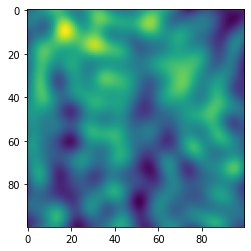

In [5]:
# test our NUFFT: 
contrast_idx = 3
nufft_config = {'img_dim':Nx,'osf':2}
# mynufft = NUFFTAdjoint(nufft_config)
output = inufft2c_torch(kdata*dcomp,ktraj,sens=None,dim=Nx)
print(np.shape(output))
plt.imshow(np.abs(np.squeeze(output[7,:,:,:].numpy())))

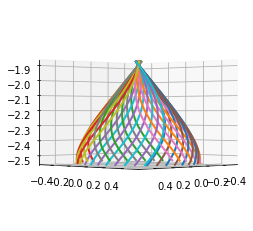

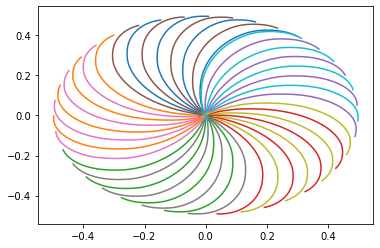

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=0, azim=45, roll=0)
# tbot, ttop = 74, 148
# tbot, ttop = 0, 73
# tbot, ttop = 209, 335
# tbot, ttop = 336, 465
# tbot, ttop = 466, 590
# tbot, ttop = 591, 671
tbot = 80
ttop = tbot+68
for ii in range(40):
    ax.plot3D(np.squeeze(rosdat['kxI'][tbot:ttop,ii]), 
              np.squeeze(rosdat['kyI'][tbot:ttop,ii]),
              np.squeeze(rosdat['t'][tbot:ttop]),linewidth=2)
plt.show()

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
for ii in range(40):
    ax2.plot(np.squeeze(rosdat['kxI'][tbot:ttop,ii]), 
              np.squeeze(rosdat['kyI'][tbot:ttop,ii]))
plt.show()


# kx_int = rosdat['kxI'][tbot:ttop,:]/np.max(np.abs(rosdat['kxI']))*50
# ky_int = rosdat['kyI'][tbot:ttop,:]/np.max(np.abs(rosdat['kyI']))*50
# kx_int = kx_int.flatten().tolist()
# kx_int = [int(x) for x in kx_int]
# ky_int = ky_int.flatten().tolist()
# ky_int = [int(y) for y in ky_int]
# print(max(kx_int))
# shots_mask = np.zeros((100,100))
# shots_mask[kx_int,ky_int] = 1
# shots_mask = np.fft.fftshift(shots_mask)
# plt.imshow(shots_mask)
# plt.show()

In [7]:
kx = torch.from_numpy(rosdat['kxI'])[tbot:ttop,:]
ky = torch.from_numpy(rosdat['kyI'])[tbot:ttop,:]

t = torch.from_numpy(rosdat['t'])
sigI = torch.from_numpy(rosdat['sigI'])[tbot:ttop,:]
print('kxI shape = ', kx.shape)

omega = torch.stack((ky.flatten(),kx.flatten()),dim=0)
omega = omega*2*torch.pi
print('omega shape = ', omega.shape) # (N, grid size, klength)
sigI = sigI.flatten()[None,None,:].type(torch.cdouble)
print('sig shape = ', sigI.shape)


kxI shape =  torch.Size([68, 40])
omega shape =  torch.Size([2, 2720])
sig shape =  torch.Size([1, 1, 2720])


In [8]:
dim = 100
dcomp = tkbn.calc_density_compensation_function(omega, (dim, dim),num_iterations=15)
print('dcomp shape = ', np.shape(dcomp))
img = inufft2c_torch(sigI*dcomp, omega, None,dim)
img = np.squeeze(img)

dcomp shape =  torch.Size([1, 1, 2720])


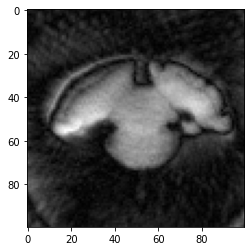

In [9]:
plt.imshow(np.squeeze(np.abs(img.numpy())), cmap='gray')

segment:  0
sigI shape =  torch.Size([1, 1, 2720])
omega shape =  torch.Size([2, 2720])
dc shape =  torch.Size([1, 1, 2720])
segment:  1
sigI shape =  torch.Size([1, 1, 2720])
omega shape =  torch.Size([2, 2720])
dc shape =  torch.Size([1, 1, 2720])
segment:  2
sigI shape =  torch.Size([1, 1, 2720])
omega shape =  torch.Size([2, 2720])
dc shape =  torch.Size([1, 1, 2720])
segment:  3
sigI shape =  torch.Size([1, 1, 2720])
omega shape =  torch.Size([2, 2720])
dc shape =  torch.Size([1, 1, 2720])
segment:  4
sigI shape =  torch.Size([1, 1, 2720])
omega shape =  torch.Size([2, 2720])
dc shape =  torch.Size([1, 1, 2720])
segment:  5
sigI shape =  torch.Size([1, 1, 2720])
omega shape =  torch.Size([2, 2720])
dc shape =  torch.Size([1, 1, 2720])
segment:  6
sigI shape =  torch.Size([1, 1, 2720])
omega shape =  torch.Size([2, 2720])
dc shape =  torch.Size([1, 1, 2720])
segment:  7
sigI shape =  torch.Size([1, 1, 2720])
omega shape =  torch.Size([2, 2720])
dc shape =  torch.Size([1, 1, 2720])


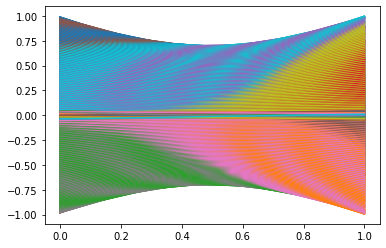

shape of image into nufft:  torch.Size([1, 1, 100, 100])
shape of kspace out of nufft:  torch.Size([1, 1, 2720])


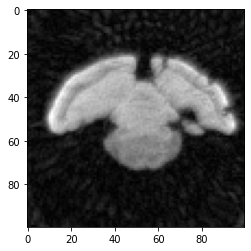

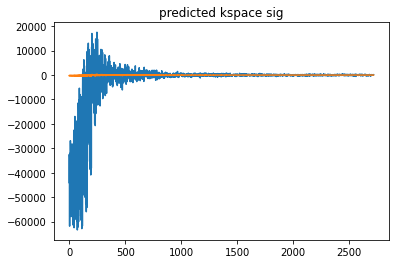

shape of image into nufft:  torch.Size([1, 1, 100, 100])
shape of kspace out of nufft:  torch.Size([1, 1, 2720])


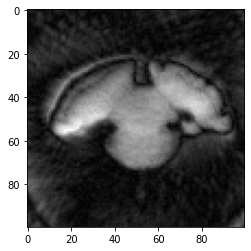

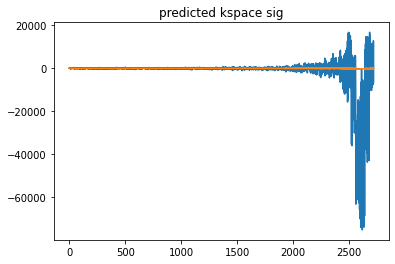

shape of image into nufft:  torch.Size([1, 1, 100, 100])
shape of kspace out of nufft:  torch.Size([1, 1, 2720])


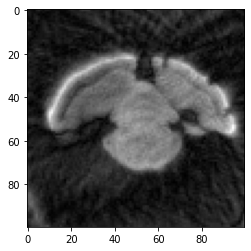

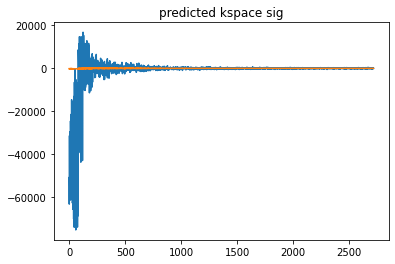

shape of image into nufft:  torch.Size([1, 1, 100, 100])
shape of kspace out of nufft:  torch.Size([1, 1, 2720])


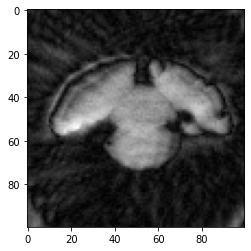

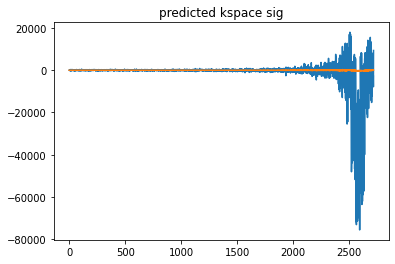

shape of image into nufft:  torch.Size([1, 1, 100, 100])
shape of kspace out of nufft:  torch.Size([1, 1, 2720])


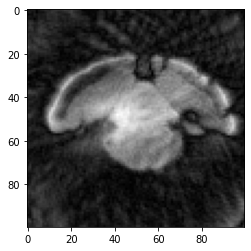

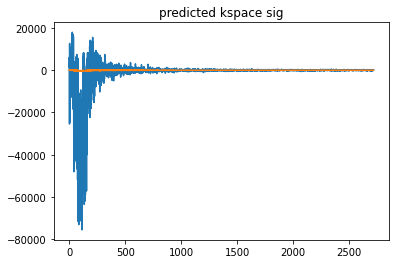

shape of image into nufft:  torch.Size([1, 1, 100, 100])
shape of kspace out of nufft:  torch.Size([1, 1, 2720])


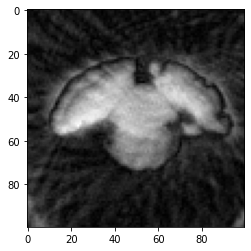

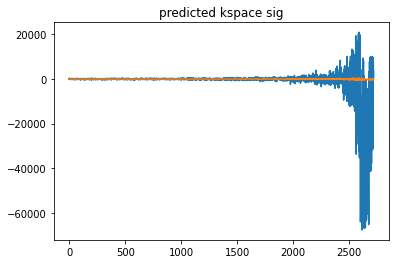

shape of image into nufft:  torch.Size([1, 1, 100, 100])
shape of kspace out of nufft:  torch.Size([1, 1, 2720])


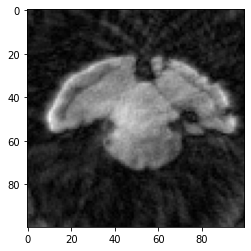

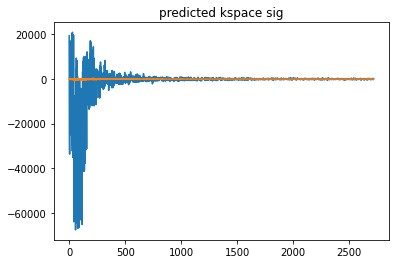

shape of image into nufft:  torch.Size([1, 1, 100, 100])
shape of kspace out of nufft:  torch.Size([1, 1, 2720])


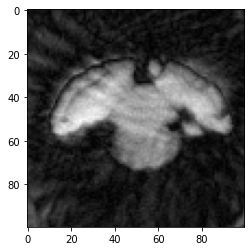

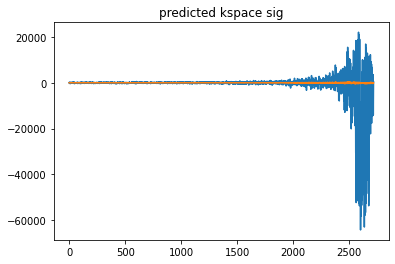

shape of image into nufft:  torch.Size([1, 1, 100, 100])
shape of kspace out of nufft:  torch.Size([1, 1, 2720])


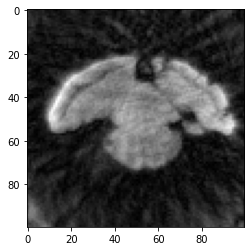

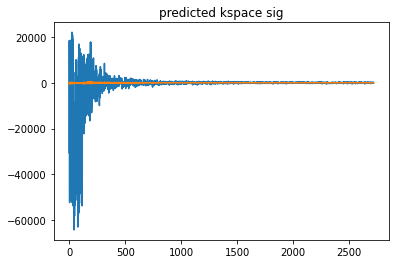

shape of image into nufft:  torch.Size([1, 1, 100, 100])
shape of kspace out of nufft:  torch.Size([1, 1, 2720])


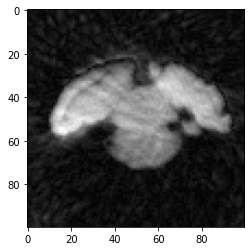

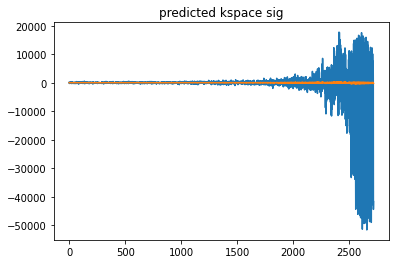

In [11]:
# for loop of the above 

bin_bots = [12, 80, 144, 208, 270, 334, 398, 462, 526, 594] 
Ro_len = 68 
bin_tops = [x+Ro_len for x in bin_bots]
dim = 100
Ncontrast = len(bin_bots)

all_sigI = torch.zeros(Ncontrast,Ro_len*Nshots, dtype=torch.cdouble)
all_omega = torch.zeros(Ncontrast,2,Ro_len*Nshots)
all_dcomp = torch.zeros(Ncontrast,1,Ro_len*Nshots, dtype=torch.cdouble)

for ii in range(len(bin_bots)):
    print('segment: ', ii)
    tbot,ttop = bin_bots[ii],bin_tops[ii]
    
    kx = torch.from_numpy(rosdat['kxI'])[tbot:ttop,:]
    ky = torch.from_numpy(rosdat['kyI'])[tbot:ttop,:]
    sigI = torch.from_numpy(rosdat['sigI'])[tbot:ttop,:]
    omega = torch.stack((ky.flatten(),kx.flatten()),dim=0)
    omega = omega*2*torch.pi
    sigI = sigI.flatten()[None,None,:].type(torch.cdouble)
   
    dcomp = tkbn.calc_density_compensation_function(omega, (dim, dim),num_iterations=15)
    
    # put all in the matrix: 
    print('sigI shape = ',np.shape(sigI))
    print('omega shape = ',np.shape(omega))
    print('dc shape = ',np.shape(dcomp))
#     img = inufft2c_torch(sigI*dcomp, omega, None,dim)

    all_sigI[ii,:] = sigI
    all_omega[ii,:,:] = omega
    all_dcomp[ii,:,:] = dcomp
plt.plot(all_omega[1,:,:]/np.pi)
plt.show()

for ii in range(len(bin_bots)):
#     print('sigI shape = ',np.shape(all_sigI[None,None,ii,:]))
#     print('omega shape = ',np.shape(all_omega[ii,:,:].squeeze()))
#     print('dc shape = ',np.shape(all_dcomp[None,ii,:,:]))
    img = inufft2c_torch(all_sigI[None,None,ii,:]*all_dcomp[None,ii,:,:], all_omega[ii,:,:].squeeze(), None,dim)

    # do the forward NUFFT: 
    print('shape of image into nufft: ', np.shape(img))
    kspace_nufft = nufft2c_torch(img, all_omega[ii,:,:].squeeze(), None, dim) * np.sqrt(all_dcomp[None,ii,:,:])
    print('shape of kspace out of nufft: ', np.shape(kspace_nufft))
    img = np.squeeze(img)
    plt.figure()
    plt.imshow(np.squeeze(np.abs(img.numpy())), cmap='gray')
    plt.figure()
    plt.plot(np.real(np.squeeze(all_sigI[None,None,ii,:])))
    plt.plot(np.real(np.squeeze(kspace_nufft)))
    plt.title('predicted kspace sig')
    plt.show()
    


In [ ]:
test = np.squeeze(np.log(np.abs(np.fft.fftshift(np.fft.fft2(img.numpy())))))
masked_kspace = shots_mask * np.squeeze((np.fft.fftshift(np.fft.fft2(img.numpy()))))
plt.imshow(test, cmap='gray')
plt.figure()
plt.imshow(shots_mask, cmap='gray')
plt.figure()
plt.imshow(np.abs(np.fft.ifft2(masked_kspace)), cmap='gray')